# 5.2 二項ロジスティック回帰

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stan_jupyter as stan
import arviz as az
from PIL import Image
import numpy as np

from utils.glaph import pairplot

import warnings
warnings.filterwarnings('ignore')

## データの確認

In [3]:
data = pd.read_csv("./data/data-attendance-2.txt")
data.head()

,PersonID,A,Score,M,Y
0,1,0,69,43,38
1,2,1,145,56,40
2,3,0,125,32,24
3,4,1,86,45,33
4,5,1,158,33,23


- PersonID: 学生のID（この節では使用しない）
- A: アルバイトが好きか（0:好きでない、1:好き）
- Score: 学問への興味の強さを数値化したもの（200点満点）
- M: 3ヶ月間における履修登録した科目の総授業回数
- Y: そのうち実際に出席した回数

## 解析の目的

前節（重回帰分析）と同じで以下とする。  
- 2つ説明変数AとScoreで応答変数Yをどれほど予測できるか知りたい。
- それぞれの説明変数が出席率にどれほど影響しているか知りたい  
ただし、応答変数はMを固定したときのYとする。

## データの分布の確認

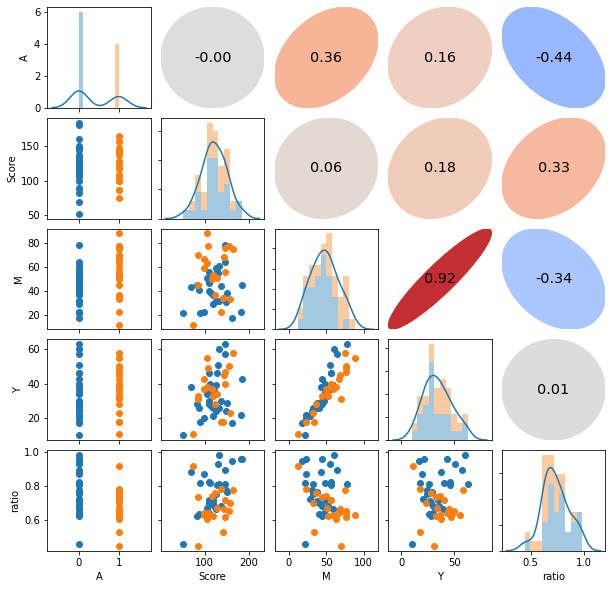

In [4]:
data_with_ratio = data.copy()
data_with_ratio["ratio"] = data["Y"] / data["M"]
pairplot(data_with_ratio.loc[:, "A":"ratio"], hue="A", corr_kws=dict(correlation="spearman"))

- ratioとScoreに正の相関がありそう
- ratioとアルバイトが好きかどうかに負の相関がありそう

## 5.2.3 メカニズムの想像

- ratio列を応答変数にして重回帰分析をすると予測値が1を超えることがあり困る
- そこで、$(-\infty, \infty)$ の範囲をとりうる線形結合 $(b_1 + b_2 A + b_3 Scrore)$ を$(0, 1)$ の範囲に変換する

→ ロジスティック関数（inverse logit）を用いる方法が一般的（Stanではinv_logit関数が用意されている）

$$
  logistic(x) = \frac{1}{1+exp(-x)}
$$

- 授業回数と出席回数のようなカウントデータの場合には二項分布を使うことが多い
- ただし、分母（出席回数）が大きくなれば、二項分布は正規分布で近似できるため正規分布を使っても良い  
  ※確率的プログラミング言語では一般的にロジスティック関数と正規分布を使う方が推定計算は高速なので便利  
    近似できるか迷う場合は、先に正規分布にあてはめてみて、問題がありそうなら二項分布に変える方法もある。

→　今回は授業回数が12～88と比較的小さいので、出席率を連続値と見なすことは難しく、二項分布を使うことにする。

以上をまとめると  

- 出席率は出席確率と解釈できる
- AとScoreの線形結合 $(b_1 + b_2 A + b_3 Scrore)$ を  
  ロジスティック関数で $(0, 1)$ の範囲に変換すると出席確率$q$が決まる
- $M$ と $q$ をパラメータとする二項分布に従って、$Y$ が生成されたと考える。


## 5.2.4 モデル式の記述

$$
\begin{align}
  &q[n] = inv\_logit(b_1 + b_2 A[n] + b_3 Score[n]) \qquad n=1,... , N \\
  &Y[n] \sim Binomial(M[n], q[n]) \qquad n=1,... , N
\end{align}
$$

## 5.2.5 Stanで実装

In [5]:
stan_model = """
data {
    int N;
    int<lower=0, upper=1> A[N];
    real<lower=0, upper=1> Score[N];  // Score/200を用いる
    int<lower=0> M[N];
    int<lower=0> Y[N];
}

parameters {
    real b1;
    real b2;
    real b3;
}

transformed parameters {
    real q[N];
    for (n in 1:N) {
        q[n] = inv_logit(b1 + b2*A[n] + b3*Score[n]);
    }
}

model {
    for (n in 1:N) {
        Y[n] ~ binomial(M[n], q[n]);
    }
}

generated quantities {
    real y_pred[N];
    for (n in 1:N) {
        y_pred[n] = binomial_rng(M[n], q[n]);
    }
}
"""

stan_data = {
    "N": len(data),
    "A": data["A"].values,
    "Score": data["Score"].values / 200,
    "M": data["M"].values,
    "Y": data["Y"].values,
}

posterior = stan.build(stan_model, data=stan_data, random_seed=1234)
fit = posterior.sample()

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_war30ga6/model_xeqgm5zn.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_war30ga6/model_xeqgm5zn.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_war30ga6/model_xeqgm5zn.stan', line 6, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

In [6]:
fit.to_frame().describe().iloc[:, :15]

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b1,b2,b3,q.1,q.2,q.3,q.4,q.5
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-1389.330094,0.936208,0.144920,3.649250,19.392500,0.0,1390.857762,0.084662,-0.620055,1.913604,0.677580,0.700733,0.782344,0.571234,0.726005
std,1.184006,0.091383,0.011329,1.084444,10.696427,0.0,1.687853,0.223460,0.092047,0.360969,0.024150,0.016077,0.011483,0.021902,0.018288
min,-1398.104224,0.229110,0.133586,1.000000,1.000000,0.0,1388.010803,-0.640769,-0.926471,0.568162,0.595118,0.638831,0.744023,0.494475,0.654110
25%,-1389.886011,0.914541,0.135622,3.000000,11.000000,0.0,1389.597585,-0.072071,-0.681064,1.664405,0.660883,0.690268,0.774804,0.556347,0.714191
50%,-1389.021387,0.972646,0.141865,4.000000,19.000000,0.0,1390.578688,0.080669,-0.618644,1.912316,0.677472,0.700916,0.782492,0.570825,0.726234
75%,-1388.457897,0.996527,0.151163,4.000000,31.000000,0.0,1391.761469,0.242137,-0.558683,2.160406,0.694664,0.711661,0.790038,0.586398,0.738404
max,-1387.856361,1.000000,0.162362,5.000000,63.000000,0.0,1401.195547,0.871584,-0.340967,3.052120,0.761937,0.755018,0.823044,0.635839,0.786138


array([[<AxesSubplot:title={'center':'b1'}>,
        <AxesSubplot:title={'center':'b1'}>],
       [<AxesSubplot:title={'center':'b2'}>,
        <AxesSubplot:title={'center':'b2'}>],
       [<AxesSubplot:title={'center':'b3'}>,
        <AxesSubplot:title={'center':'b3'}>],
       [<AxesSubplot:title={'center':'q'}>,
        <AxesSubplot:title={'center':'q'}>],
       [<AxesSubplot:title={'center':'y_pred'}>,
        <AxesSubplot:title={'center':'y_pred'}>]], dtype=object)

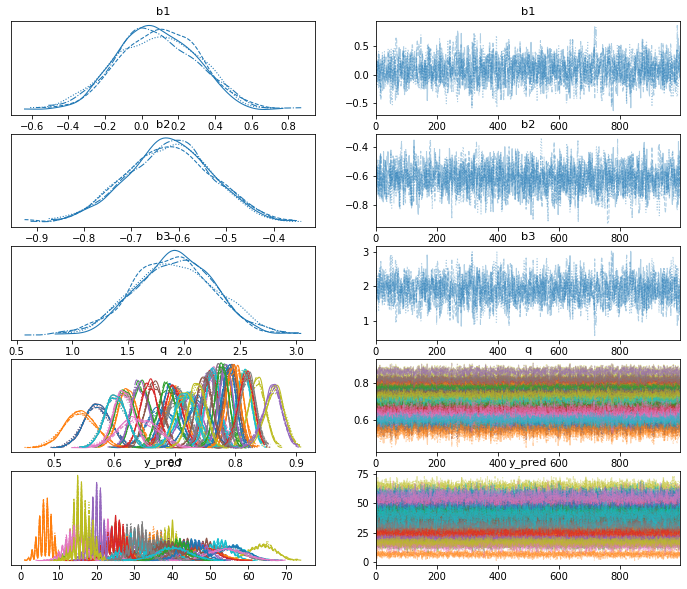

In [7]:
az.plot_trace(fit)

## 推定結果の解釈

得られた事後平均の値をモデル式に代入

$$
\begin{align*}
  &q[n] = inv\_logit(0.09 - 0.62 A[n] + 1.90 Score[n]/200) \qquad n=1,... , N \\
  &Y[n] \sim Binomial(M[n], q[n]) \qquad n=1,... , N
\end{align*}
$$

ロジスティック関数はロジット関数の逆関数であり、ロジット関数は対数オッズ比であるから
$$
  logstic(z) = inv\_logit(z) = \frac{1}{1+exp(-x)} \tag{1}
$$
$$
  logit(q) = \log \frac{q_i}{1-q_i} \tag{2}
$$

(1)式を変形すると

$$
  \frac{q}{1-q} = exp(z)
$$

となり、左辺はオッズ比。この節の結果を代入すると次にようになる。

$$
\begin{align*}
  \frac{q}{1-q} 
  & = exp(0.09 - 0.62A + 1.90 \frac{Score}{200}) \\
  & = exp(0.09) exp(-0.62A) exp(1.90 \frac{Score}{200})
\end{align*}
$$

Scoreが150点の学生のオッズ比は50点の学生のオッズ比の約2.6倍

$$
\begin{align*}
   \frac{odds(Score=150)}{odds(Score=50)}
   &= \frac{exp(0.09)exp(-0.62A)exp(1.90\frac{150}{200})}
           {exp(0.09)exp(-0.62A)exp(1.90\frac{50}{200})} \\
   &= \frac{exp(1.90\frac{150}{200})}
           {exp(1.90\frac{50}{200})}
   = exp(1.90 \frac{150-50}{200})
   \approx 2.6
\end{align*}
$$

アルバイト好きな学生のオッズ比はそうでない学生のオッズ比の約0.54倍

$$
\begin{align*}
   \frac{odds(A=1)}{odds(A=0)}
   &= \frac{exp(-0.62 * 1)}
           {exp(-0.62 * 0)}
   = exp(-0.62 * 1)
   \approx 0.54
\end{align*}
$$

## 5.2.7 図によるモデルのチェック

In [8]:
pred_cols = fit.to_frame().columns[-50:]
predicted = fit.to_frame().describe().loc["mean", pred_cols].values
predicted

array([29.0915 , 39.222  , 25.054  , 25.65725, 24.007  , 48.5925 ,
       37.1635 , 53.5145 , 63.5115 , 52.05375, 23.5545 , 35.29075,
       34.1075 , 30.36725, 42.28475, 35.53425, 28.993  , 31.70625,
       38.92875, 55.62525, 39.999  , 47.84725, 38.81625, 47.3795 ,
       32.1325 , 33.98925, 22.45125, 28.64175, 15.0685 , 37.3955 ,
       55.5095 ,  6.507  , 15.8115 , 24.40225, 46.25725, 43.59925,
       54.1175 , 35.5555 , 15.8035 , 29.426  , 44.965  , 25.4035 ,
       41.3125 , 25.38075, 19.833  , 38.21825, 14.10375, 31.11025,
       16.98   , 40.2245 ])

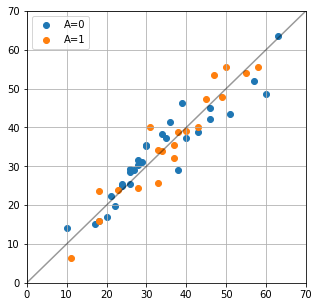

In [9]:
fig = plt.figure(figsize=(5, 5))
idx_0 = data.query("A == 0").index
idx_1 = data.query("A == 1").index
plt.scatter(data.loc[idx_0, "Y"], predicted[idx_0], label="A=0")
plt.scatter(data.loc[idx_1, "Y"], predicted[idx_1], label="A=1")
plt.plot([0, 70], [0, 70], alpha=.4, color="black")
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.legend()
plt.grid()
plt.show()

# 5.3 ロジスティック回帰

## データの確認

In [10]:
data = pd.read_csv("./data/data-attendance-3.txt")
data.head()

,PersonID,A,Score,Weather,Y
0,1,0,69,B,1
1,1,0,69,A,1
2,1,0,69,C,1
3,1,0,69,A,1
4,1,0,69,B,1


→　出欠データ毎になっている（3.2節では学生ごと）

- PersonID: 学生のID（この節では使用しない）
- A: アルバイトが好きか（0:好きでない、1:好き）
- Score: 学問への興味の強さを数値化したもの（200点満点）
- Weather: 天気（A：晴れ、B：曇り、C：雨）
- Y: 授業に出席したか（0：欠席、1：出席）

## 5.3.1 解析の目的

- 3つの説明変数（A、Score、Weather）で応答変数Yがどれほど予測できるか
- それぞれの説明変数が出席確率にどれほど影響しているか

## 5.3.2 データの分布の確認

In [11]:
pd.crosstab(data["Weather"], data["Y"])

Y,0,1
Weather,,
A,306,953
B,230,500
C,138,269


## 5.3.3 背景知識を使った値の変換

- Weatherは「A、B、C」をそれぞれ「0、0.2、1」に置換
- これは経験から曇りの影響と雨の影響の大きさの比を1：5に固定したことに相当

→ こういった背景知識を仮定としてモデルに組み込むのはモデリングの重要なステップ

In [12]:
mapping = {"A": 0.0, "B": 0.2, "C": 1.0}
data["Weather"] = data["Weather"].map(mapping)
data

,PersonID,A,Score,Weather,Y
0,1,0,69,0.2,1
1,1,0,69,0.0,1
2,1,0,69,1.0,1
3,1,0,69,0.0,1
4,1,0,69,0.2,1
...,...,...,...,...,...
2391,50,1,99,0.2,1
2392,50,1,99,0.0,1
2393,50,1,99,0.0,1
2394,50,1,99,1.0,1


## 5.3.4 メカニズムの想像

- 5.2節と同じだが、二項分布ではなくベルヌーイ分布を仮定。

## 5.3.5 モデル式の記述

$$
\begin{align*}
  &q[i] = inv\_logit(b_1 + b_2 A[i] + b_3 Score[i] + b_4 Weather[i]) \qquad i=1,... , I \\
  &Y[i] \sim Bernoulli(q[i]) \qquad i=1,... , I
\end{align*}
$$

- データは学生ごとではなく、出欠ごとになっている。
- 本来、授業回数が60回の学生は、20回の学生に比べて、尤度の面で3倍の重みがついている。
- 学生によって出席行動に差があること等を考慮していない  
  →　学生による差が大きいと仮定すれば、8章で扱う階層モデルにつながる  
  ※今回は「簡単な仮定から始める」という原則に従ってこのまま解析を進める


## 5.3.6 Stanで実装

In [13]:
stan_model = """
data {
  int I;
  int<lower=0, upper=1> A[I];
  real<lower=0, upper=1> Score[I];
  real<lower=0, upper=1> W[I];
  int<lower=0, upper=1> Y[I];
}

parameters {
  real b[4];
}

transformed parameters {
  real q[I];
  for (i in 1:I)
    q[i] = inv_logit(b[1] + b[2]*A[i] + b[3]*Score[i] + b[4]*W[i]);
}

model {
  for (i in 1:I)
    Y[i] ~ bernoulli(q[i]);
}
"""

stan_model = """
data {
  int I;
  int<lower=0, upper=1> A[I];
  real<lower=0, upper=1> Score[I];
  real<lower=0, upper=1> W[I];
  int<lower=0, upper=1> Y[I];
}

parameters {
  real b[4];
}

model {
  for (i in 1:I)
    Y[i] ~ bernoulli_logit(b[1] + b[2]*A[i] + b[3]*Score[i] + b[4]*W[i]);
}
"""

stan_data = {
    "I": len(data),
    "A": data["A"].values,
    "Score": data["Score"].values / 200,
    "W": data["Weather"].values,
    "Y": data["Y"].values,
}

posterior = stan.build(stan_model, data=stan_data, random_seed=1234)
fit = posterior.sample()

Building...

In file included from /usr/local/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:7,
                 from /root/.cache/httpstan/4.7.1/models/kakm6e6z/model_kakm6e6z.cpp:2:
/usr/local/lib/python3.10/site-packages/httpstan/include/stan/io/dump.hpp: In member function ‘virtual std::vector<std::complex<double> > stan::io::dump::vals_c(const string&) const’:
/usr/local/lib/python3.10/site-packages/httpstan/include/stan/io/dump.hpp:694:52: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<double, std::allocator<double> >::size_type’ {aka ‘long unsigned int’} [-Wsign-compare]
  694 |       for (comp_iter = 0, real_iter = 0; real_iter < val_r->second.first.size();
      |                                          ~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~
/usr/local/lib/python3.10/site-packages/httpstan/include/stan/io/dump.hpp:707:24: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<int>::s


Building: 39.6s, done.Messages from stanc:
Warning in '/tmp/httpstan_lgxut0pr/model_kakm6e6z.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_lgxut0pr/model_kakm6e6z.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_lgxut0pr/model_kakm6e6z.stan', line 6, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to


In [14]:
fit.to_frame().describe()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b.1,b.2,b.3,b.4
count,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-1383.110425,0.919680,0.161153,4.00225,21.635500,0.0,1385.130048,0.167387,-0.618919,1.960887,-0.458306
std,1.434810,0.109554,0.010662,0.85961,9.464118,0.0,2.045981,0.234821,0.094157,0.375332,0.125673
min,-1391.650405,0.234952,0.148312,1.00000,1.000000,0.0,1381.339351,-0.597432,-0.932720,0.797823,-0.937580
25%,-1383.821842,0.886029,0.154319,4.00000,15.000000,0.0,1383.649926,0.003391,-0.682989,1.710175,-0.542494
50%,-1382.769100,0.965141,0.159443,4.00000,23.000000,0.0,1384.761385,0.166567,-0.619724,1.949327,-0.458450
75%,-1382.063002,0.994901,0.166277,5.00000,31.000000,0.0,1386.213345,0.326169,-0.553650,2.224229,-0.372337
max,-1381.072762,1.000000,0.177412,5.00000,31.000000,0.0,1395.365014,0.942148,-0.235264,3.208309,0.027129


array([[<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>]], dtype=object)

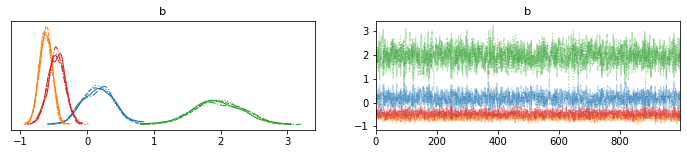

In [15]:
az.plot_trace(fit)

## 5.3.7 図によるモデルのチェック

- 応答変数Yとqの信頼区間を重ねて描画  
  → モデルの妥当性チェック

※書きにくいためA=0, Weather=Aの場合だけを表示

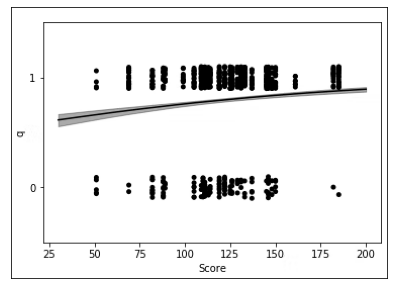

In [29]:
def img_show(img_path: str):
    img = Image.open(img_path)
    img_array = np.asarray(img)
    fig = plt.figure(figsize=(7, 5))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_array)
    plt.show()

img_show("./data/5-3-7_1.png")

### 確率と実測値のプロット

先ほどの図は説明変数が増えると可視化が難しくなるためバイオリン図を用いる。

→ 十分には予測ができていないと判断

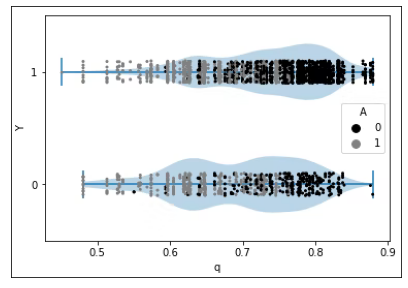

In [30]:
img_show("./data/5-3-7_2.png")

### ROC曲線

本書では詳しく説明しないが興味のある人は下記を参照

https://oku.edu.mie-u.ac.jp/~okumura/stat/ROC.html

AUC（曲線の下の面積）は0.8以上が目安だが、今回は0.6169のため分類性能はあまりよくないと言える。

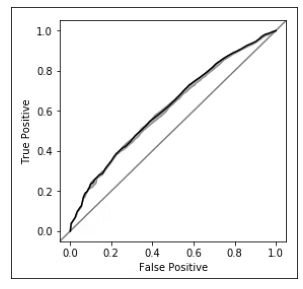

In [31]:
img_show("./data/5-3-7_3.png")